In [255]:
from __future__ import print_function
from __future__ import division

from collections import OrderedDict
import os
import sys
import warnings

import argparse
import logging
import h5py as h5
import numpy as np
import pandas as pd
import scipy.io

import six
from six.moves import range
import csv
import math as ma
from sklearn.metrics import roc_auc_score, confusion_matrix, average_precision_score,roc_curve,auc,precision_recall_curve
from keras.preprocessing import sequence
from keras.optimizers import RMSprop,Adam, Adadelta, Nadam, Adamax, SGD, Adagrad
from keras.models import Sequential
from keras.layers.core import  Dropout, Activation, Flatten
from keras.regularizers import l1,l2,l1_l2
from keras.constraints import maxnorm
#from keras.layers.recurrent import LSTM, GRU
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Conv1D, MaxPooling1D, Dense, LSTM, Bidirectional
from sklearn.ensemble import GradientBoostingClassifier
import matplotlib.pyplot as plt

import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model

In [256]:
 h5filename = "histonemodTF_resample_ncl_GM12878.h5"
 h5file = h5.File(h5filename,'r')
 input_features = h5file['input/H3K27ac_RPKM']
 output_H3K4me3 = h5file['output/H3K27ac']
 
 input_features = np.array(input_features)
 output_H3K4me3 = np.array(output_H3K4me3)
 output_H3K4me3_reshape = output_H3K4me3.reshape(len(output_H3K4me3),1)

In [257]:
 #combine the label with input dna  
input_features_label = np.concatenate((input_features,output_H3K4me3_reshape), axis=1)
H3K4me3_df = pd.DataFrame(output_H3K4me3)
pos_label= H3K4me3_df.loc[H3K4me3_df.iloc[:,0]==1]
pos_label_ix = np.array(pos_label.index)
neg_label = H3K4me3_df.loc[H3K4me3_df.iloc[:,0]==0]
neg_label_ix = np.array(neg_label.index)
pos_sam_H3K4me3 = input_features_label[pos_label_ix,:]
neg_sam_H3K4me3 = input_features_label[neg_label_ix,:]
np.random.shuffle(pos_sam_H3K4me3)
np.random.shuffle(neg_sam_H3K4me3)
print(pos_sam_H3K4me3.shape)
print(neg_sam_H3K4me3.shape)   

(7826, 52)
(18185, 52)


In [258]:
#trainset
#if K562 set y to 43, for H1 set y to 30 and for GM12878 set y to 51 
train_neg_sample = int(ma.ceil(neg_sam_H3K4me3.shape[0] *0.7))
train_pos_sample = int(ma.ceil(pos_sam_H3K4me3.shape[0] *0.7))
train_neg_H3K4me3 = neg_sam_H3K4me3[0:train_neg_sample,:]
train_pos_H3K4me3 = pos_sam_H3K4me3 [0:train_pos_sample,:]
train_neg_pos_H3K4me3 = np.concatenate((train_neg_H3K4me3, train_pos_H3K4me3),axis = 0)
np.random.shuffle(train_neg_pos_H3K4me3)
X_train_H3K4me3 = train_neg_pos_H3K4me3[:,0:51]
Y_train_H3K4me3 = train_neg_pos_H3K4me3[:,51]
Y_train_H3K4me3 = np.array(Y_train_H3K4me3, dtype='int8')
frq = np.bincount(Y_train_H3K4me3)
#print(frq)
print(X_train_H3K4me3.shape)
print(Y_train_H3K4me3.shape)
print(Y_train_H3K4me3[0:100])

(18209, 51)
(18209,)
[0 0 0 1 0 1 0 0 1 0 1 1 0 1 0 0 0 0 1 0 0 0 0 1 0 1 0 0 0 0 1 1 1 0 0 0 0
 0 0 0 1 1 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 1 0 0 0 0 1 0 1 0 0 0 1 0 0 1 0 0
 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 1 1 0 0 1]


In [259]:
#validation set
val_neg_sample = train_neg_sample + int(ma.ceil(neg_sam_H3K4me3.shape[0] *0.1))
val_pos_sample = train_pos_sample + int(ma.ceil(pos_sam_H3K4me3.shape[0] *0.1))
val_neg_H3K4me3 = neg_sam_H3K4me3[train_neg_sample:val_neg_sample,:]
val_pos_H3K4me3 = pos_sam_H3K4me3[train_pos_sample:val_pos_sample,:]
val_neg_pos_H3K4me3 = np.concatenate((val_neg_H3K4me3, val_pos_H3K4me3),axis = 0)
np.random.shuffle(val_neg_pos_H3K4me3)
X_val_H3K4me3 = val_neg_pos_H3K4me3[:,0:51]
Y_val_H3K4me3 = val_neg_pos_H3K4me3[:,51]
Y_val_H3K4me3 = np.array(Y_val_H3K4me3, dtype='int8')
frq = np.bincount(Y_val_H3K4me3)
print(frq)
print(X_val_H3K4me3.shape)
print(Y_val_H3K4me3.shape)   
print(X_val_H3K4me3.shape)

[1819  783]
(2602, 51)
(2602,)
(2602, 51)


In [260]:
#test set
test_neg_H3K4me3 = neg_sam_H3K4me3[val_neg_sample:,:]
test_pos_H3K4me3 = pos_sam_H3K4me3 [val_pos_sample:,:]
test_neg_pos_H3K4me3 = np.concatenate((test_neg_H3K4me3, test_pos_H3K4me3),axis = 0)
np.random.shuffle(test_neg_pos_H3K4me3)
X_test_H3K4me3 = test_neg_pos_H3K4me3[:,0:51]
Y_test_H3K4me3 = test_neg_pos_H3K4me3[:,51]
Y_test_H3K4me3 = np.array(Y_test_H3K4me3, dtype='int8')
frq = np.bincount(Y_test_H3K4me3)
print(frq)
print(X_test_H3K4me3.shape)
print(Y_test_H3K4me3.shape) 

[3636 1564]
(5200, 51)
(5200,)


In [261]:
#building model
model = Sequential()
model.add(Dense(units=256, input_dim= 51, activation="relu",kernel_initializer='glorot_uniform')) 
model.add(Dropout(0.3))
model.add(Dense(units=180,  activation="relu",kernel_initializer='glorot_uniform'))
model.add(Dropout(0.3))
model.add(Dense(units= 60, activation="relu",kernel_initializer='glorot_uniform')) 
model.add(Dense(units=1,  activation="sigmoid"))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_125 (Dense)            (None, 256)               13312     
_________________________________________________________________
dropout_63 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_126 (Dense)            (None, 180)               46260     
_________________________________________________________________
dropout_64 (Dropout)         (None, 180)               0         
_________________________________________________________________
dense_127 (Dense)            (None, 60)                10860     
_________________________________________________________________
dense_128 (Dense)            (None, 1)                 61        
Total params: 70,493
Trainable params: 70,493
Non-trainable params: 0
_________________________________________________________________


In [262]:
 adam = Adam(lr = 0.0001)
 model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
 print('running at most 60 epochs')
 checkpointer = ModelCheckpoint(filepath="HistoneMark_H3K9ac_TF_ncl_GM12878.hdf5",verbose=1, monitor='val_loss',save_best_only=True)
 earlystopper = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
 model.fit(X_train_H3K4me3, Y_train_H3K4me3, batch_size=16, epochs=90, shuffle=True, validation_data=( X_val_H3K4me3, Y_val_H3K4me3), callbacks=[checkpointer,earlystopper])
 #model.fit(X_train_s, Y_train_s, batch_size=12, epochs=50, shuffle=True, validation_data=( X_val_s, Y_val_s), callbacks=[checkpointer,earlystopper])
 y_pred = model.predict(X_test_H3K4me3)
 
 #np.savetxt('H3K27me3_true.csv', Y_test_H3K4me3, delimiter=",")
 #np.savetxt('H3K9ac_pred.csv', y_pred, delimiter=",")
 #y_pred = model.predict(X_test_s)
 #tresults = model.evaluate(X_test_s, Y_test_s)
 tresults = model.evaluate(X_test_H3K4me3, Y_test_H3K4me3)
 print(tresults)
 #model.summary()
 #print(roc_auc_score(Y_test_s,y_pred))
 print(roc_auc_score(Y_test_H3K4me3, y_pred))
 aupr = average_precision_score(Y_test_H3K4me3, y_pred)
 print(aupr)
    




running at most 60 epochs
Train on 18209 samples, validate on 2602 samples
Epoch 1/90
17984/18209 [============================>.] - ETA: 0s - loss: 0.3051 - acc: 0.8974
Epoch 00001: val_loss improved from inf to 0.19161, saving model to HistoneMark_H3K9ac_TF_ncl_GM12878.hdf5
18209/18209 [==============================] - 6s 308us/step - loss: 0.3045 - acc: 0.8978 - val_loss: 0.1916 - val_acc: 0.9427
Epoch 2/90
18208/18209 [============================>.] - ETA: 0s - loss: 0.1811 - acc: 0.9481
Epoch 00002: val_loss improved from 0.19161 to 0.17258, saving model to HistoneMark_H3K9ac_TF_ncl_GM12878.hdf5
18209/18209 [==============================] - 3s 190us/step - loss: 0.1811 - acc: 0.9481 - val_loss: 0.1726 - val_acc: 0.9485
Epoch 3/90
18144/18209 [============================>.] - ETA: 0s - loss: 0.1598 - acc: 0.9525
Epoch 00003: val_loss improved from 0.17258 to 0.16704, saving model to HistoneMark_H3K9ac_TF_ncl_GM12878.hdf5
18209/18209 [==============================] - 4s 207us/s

Epoch 30/90
18032/18209 [============================>.] - ETA: 0s - loss: 0.0845 - acc: 0.9718
Epoch 00030: val_loss did not improve
18209/18209 [==============================] - 3s 171us/step - loss: 0.0845 - acc: 0.9717 - val_loss: 0.1177 - val_acc: 0.9608
Epoch 31/90
18096/18209 [============================>.] - ETA: 0s - loss: 0.0790 - acc: 0.9728
Epoch 00031: val_loss improved from 0.11282 to 0.11218, saving model to HistoneMark_H3K9ac_TF_ncl_GM12878.hdf5
18209/18209 [==============================] - 3s 171us/step - loss: 0.0790 - acc: 0.9727 - val_loss: 0.1122 - val_acc: 0.9627
Epoch 32/90
18160/18209 [============================>.] - ETA: 0s - loss: 0.0803 - acc: 0.9735
Epoch 00032: val_loss did not improve
18209/18209 [==============================] - 3s 169us/step - loss: 0.0802 - acc: 0.9735 - val_loss: 0.1159 - val_acc: 0.9627
Epoch 33/90
18128/18209 [============================>.] - ETA: 0s - loss: 0.0783 - acc: 0.9734
Epoch 00033: val_loss did not improve
18209/1820

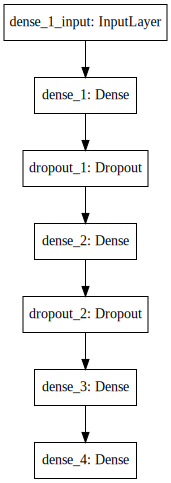

In [8]:
plot_model(model, to_file='model_H1_TF_H3K4me3.png')
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [202]:
Y_test_H3K4me3_lr = pd.read_csv('H3K27me3_lr_true.csv')
Y_test_H3K4me3_lr = Y_test_H3K4me3_lr.values
y_pred_lr = pd.read_csv('H3K27me3_lr_pred.csv')
y_pred_lr = y_pred_lr.values

0.801568280998


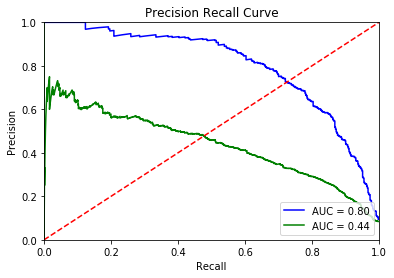

In [203]:
precision, recall, thresholds = precision_recall_curve(Y_test_H3K4me3, y_pred)
pr_auc = aupr
print(pr_auc)
precision_lr, recall_lr, thresholds_lr = precision_recall_curve(Y_test_H3K4me3_lr, y_pred_lr)
pr_auc_lr = average_precision_score(Y_test_H3K4me3_lr, y_pred_lr)
plt.title('Precision Recall Curve')
plt.plot(recall, precision, 'b', label = 'AUC = %0.2f' % pr_auc)
plt.plot(recall_lr, precision_lr, 'g', label = 'AUC = %0.2f' % pr_auc_lr)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

In [119]:
 y_pred = (y_pred>0.5)
 cm = confusion_matrix(Y_test_H3K4me3, y_pred)
 print(cm)

[[2957   40]
 [  63 2309]]
